# Goal
This notebook aims to predict cholera cases and deaths and Yemen using a machine learning model. The dataset was openly sourced from [1](https://www.datacamp.com/workspace/external-link?url=https%3A%2F%2Fdata.as-rcp.org%2FDatacatalog%2FDataset%2Fun-agencies%252Fhdx%252FYemen%2520Country%2520Level%2520Cholera%2520Epidemiology%2520Data%2520csv_10122022042615). I will be predominantly using `pandas`, `bayesian-optimization`, `xgb`, `scipy` libraries.



# Overall workflow
1. Load the dataset.
2. Convert cumulative values to non-cumulative, remove the latest date, and resample the data to a weekly time resolution with uniform spacing.
3. Standardize the non-cumulative cases and deaths.
4. Calculate the autocorrelation for cases and deaths for lags up to 52 weeks.
5. Identify the peaks in the autocorrelation using scipy.signal.find_peaks.
6. Determine the maximum lag for cases and deaths that yield the maximum autocorrelation.
7. Plot the autocorrelation for both cases and deaths, highlighting the maximum lags with vertical red lines.
8. ML Part: Prepare the Data. Create lagged features based on the maximum lags for cases and deaths.
9. Split the Data: Split the data into training and testing sets.
10. Bayesian Optimization: Use Bayesian optimization to find the optimal hyperparameters for the XGBoost model.
11. Train and Predict: Train the XGBoost model with the optimal hyperparameters and make predictions for cases and deaths.
12. Calculate the RMSE.
13. Predict the cases and deaths for 1 week after the last available date using the trained models.
14. Reverse the standardization process to get the predictions in the original scale.
15. Assess the predictions.




In [ ]:
# !pip install bayesian-optimization

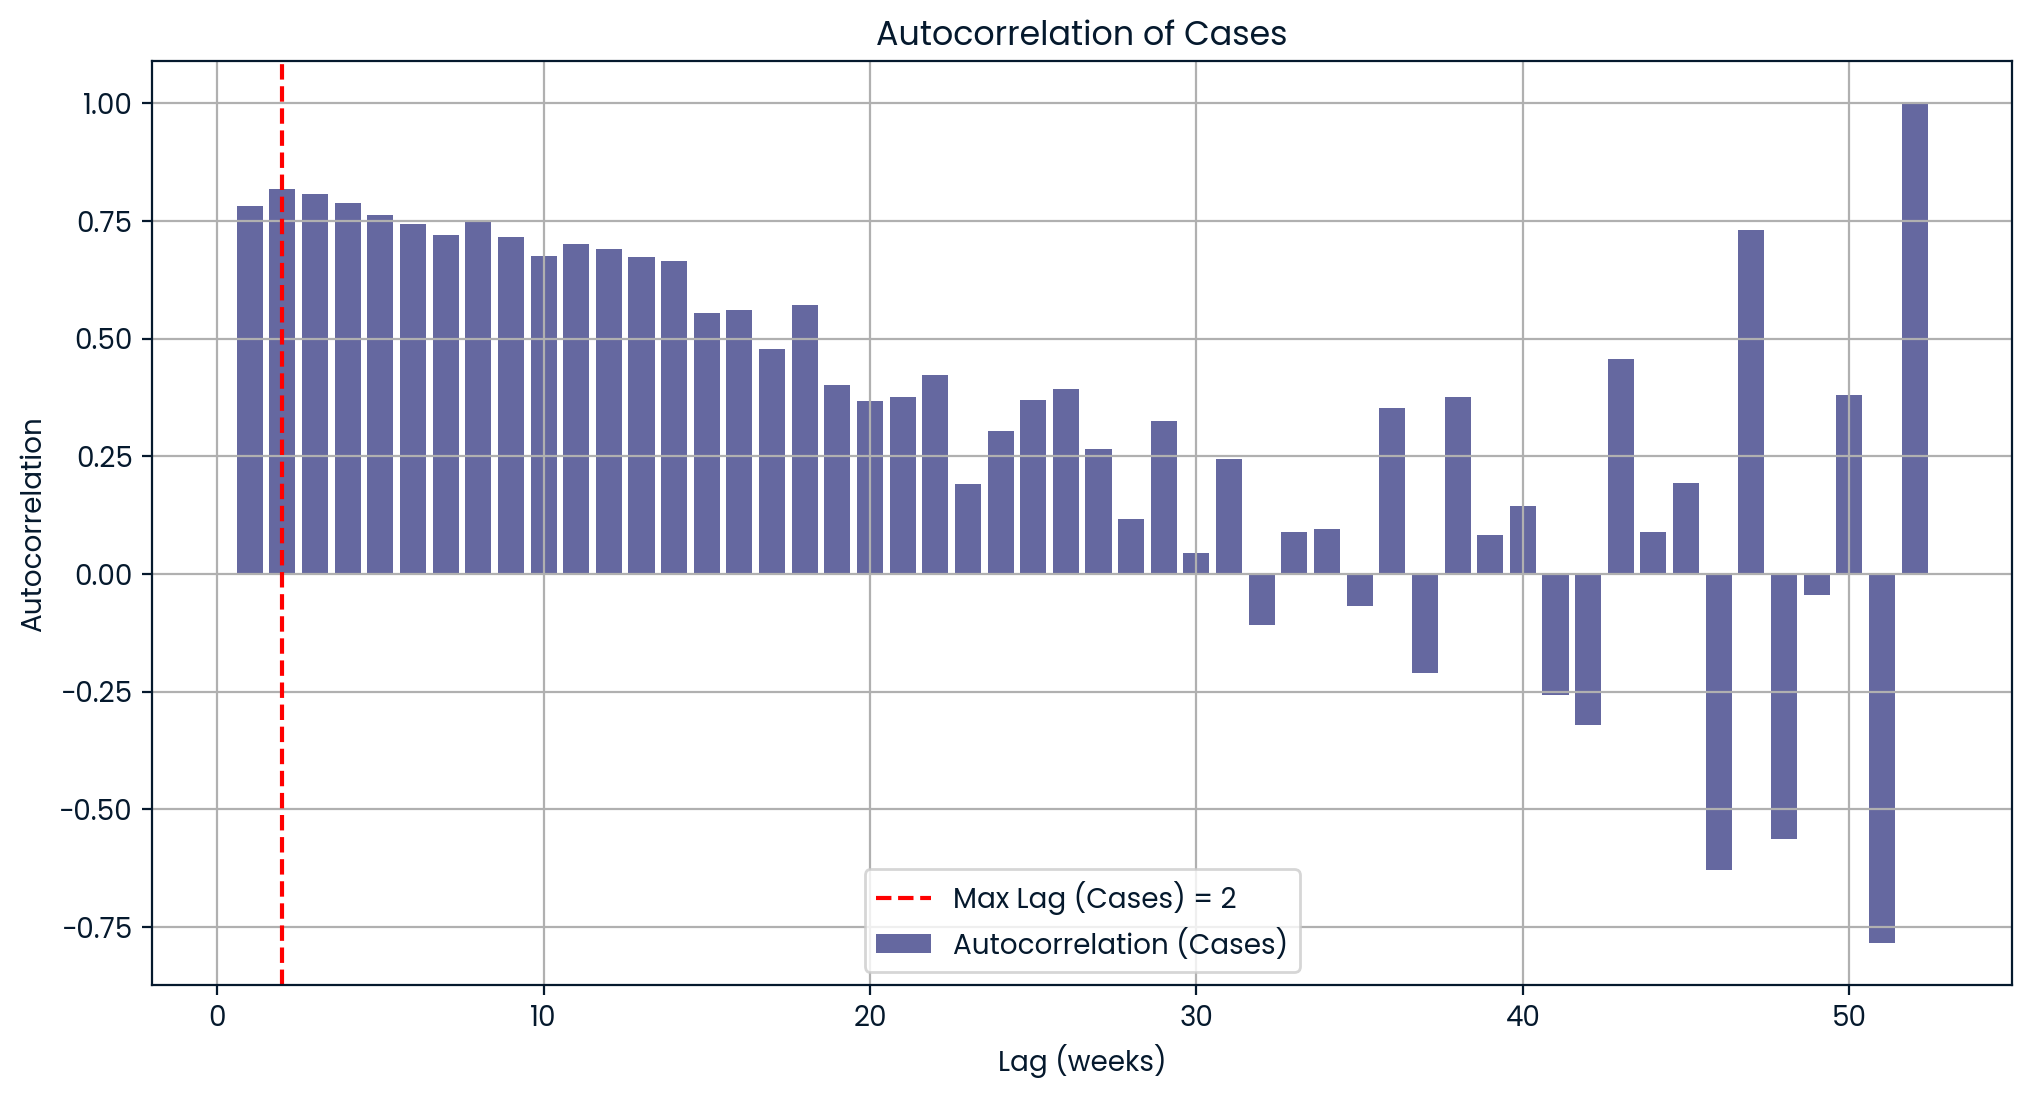

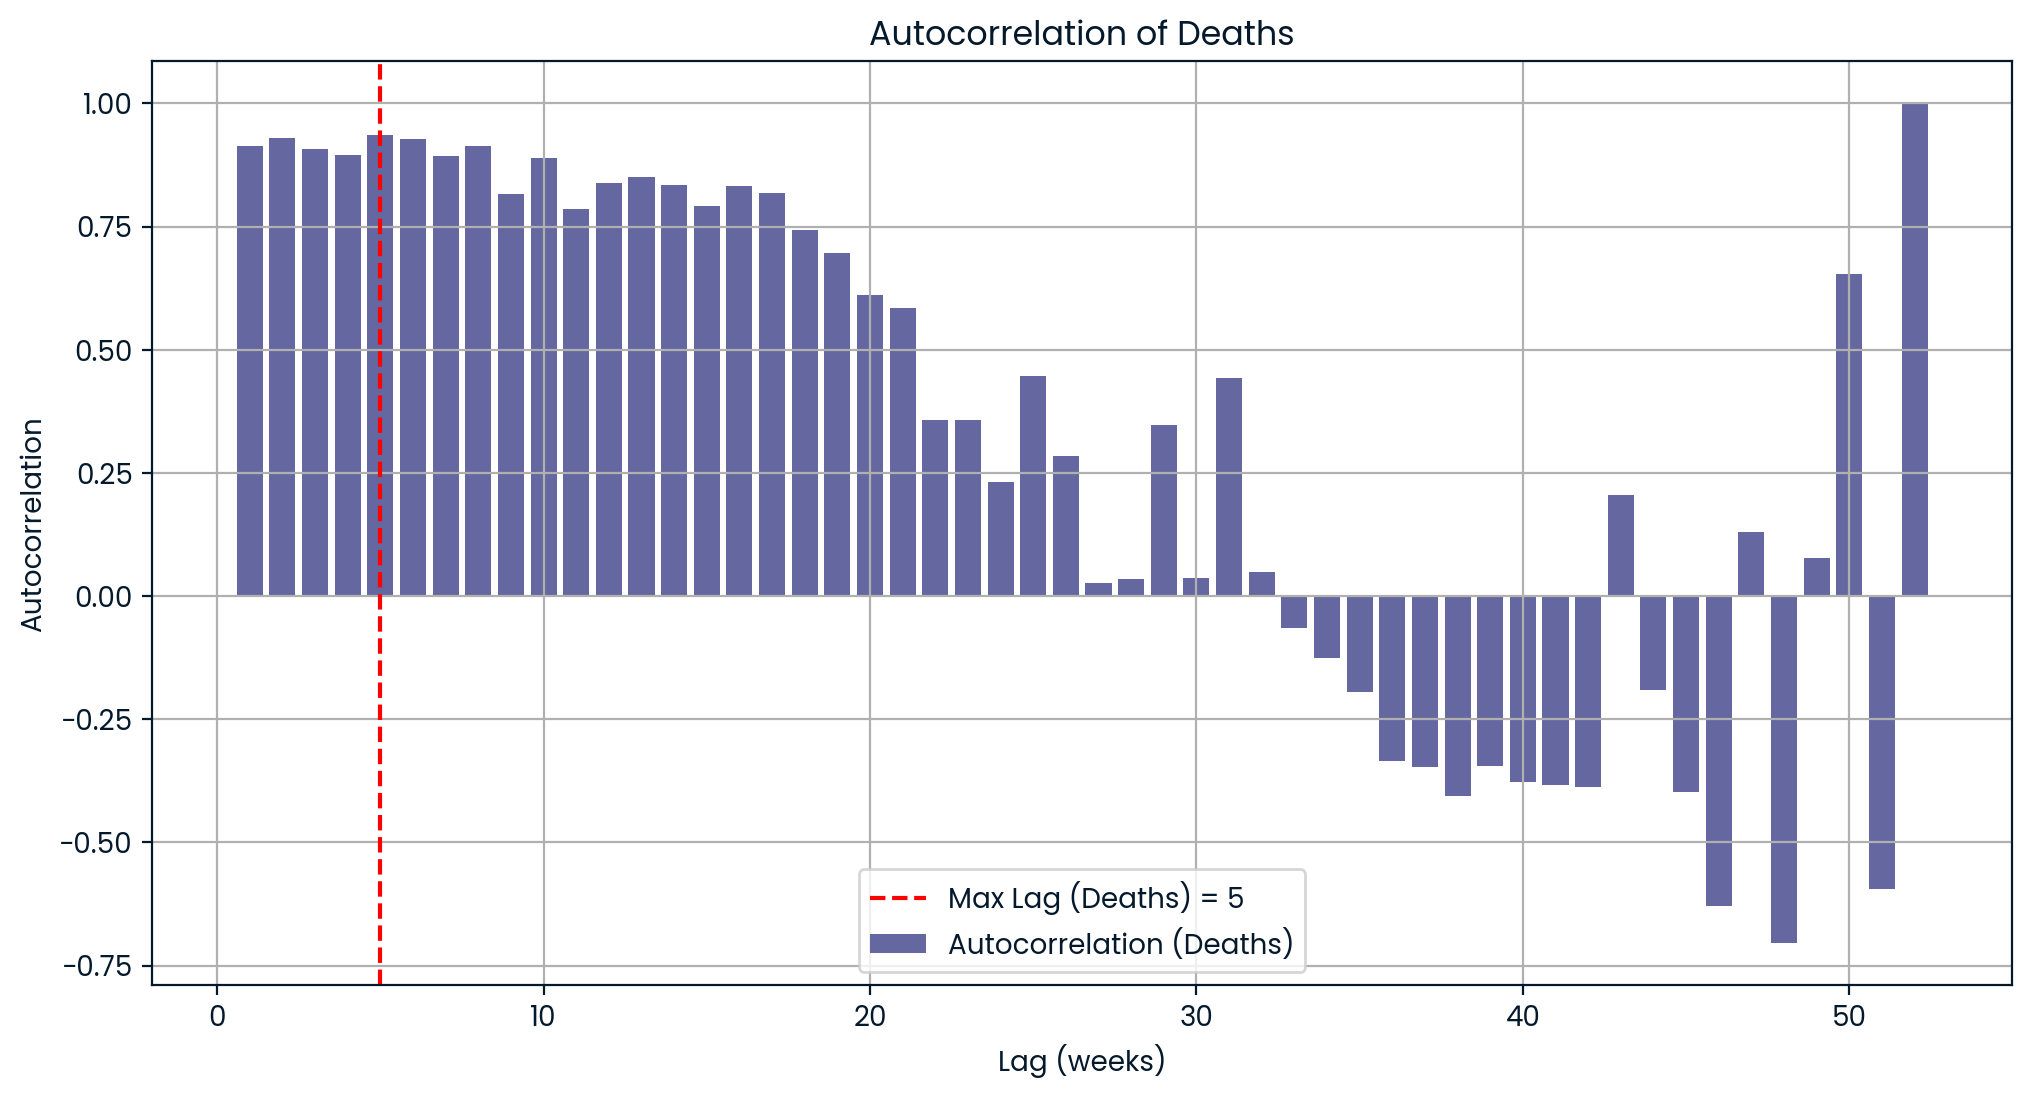

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
from bayes_opt import BayesianOptimization

# Load the dataset
export_yemen_cholera = pd.read_csv('Export-yemen-cholera.csv')

# Convert the Date column to datetime format
export_yemen_cholera['Date'] = pd.to_datetime(export_yemen_cholera['Date'])

# Sort the data by Date
export_yemen_cholera = export_yemen_cholera.sort_values(by='Date')

# Calculate non-cumulative values for Deaths and Cases
export_yemen_cholera['Non_Cumulative_Deaths'] = export_yemen_cholera['Deaths'].diff().fillna(export_yemen_cholera['Deaths'])
export_yemen_cholera['Non_Cumulative_Cases'] = export_yemen_cholera['Cases'].diff().fillna(export_yemen_cholera['Cases'])

# Remove the latest date
export_yemen_cholera = export_yemen_cholera.iloc[:-1]

# Resample the data to a weekly time resolution with uniform spacing
export_yemen_cholera.set_index('Date', inplace=True)
weekly_data_uniform = export_yemen_cholera.resample('W').sum()

# Standardize the data
scaler = StandardScaler()
weekly_data_uniform[['Non_Cumulative_Deaths', 'Non_Cumulative_Cases']] = scaler.fit_transform(weekly_data_uniform[['Non_Cumulative_Deaths', 'Non_Cumulative_Cases']])

# Calculate autocorrelation for cases and deaths
autocorr_cases = [weekly_data_uniform['Non_Cumulative_Cases'].autocorr(lag=i) for i in range(1, 53)]
autocorr_deaths = [weekly_data_uniform['Non_Cumulative_Deaths'].autocorr(lag=i) for i in range(1, 53)]

# Find peaks in autocorrelation
peaks_cases, _ = find_peaks(autocorr_cases)
peaks_deaths, _ = find_peaks(autocorr_deaths)

# Sort peaks by their values
sorted_peaks_cases = sorted(peaks_cases, key=lambda x: autocorr_cases[x], reverse=True)
sorted_peaks_deaths = sorted(peaks_deaths, key=lambda x: autocorr_deaths[x], reverse=True)

# Determine the max lag for cases and deaths
max_lag_cases = sorted_peaks_cases[0] + 1
max_lag_deaths = sorted_peaks_deaths[0] + 1





# Plot autocorrelation for cases
plt.figure(figsize=(12, 6))
plt.bar(range(1, 53), autocorr_cases, label='Autocorrelation (Cases)')
plt.axvline(x=max_lag_cases, color='red', linestyle='--', label=f'Max Lag (Cases) = {max_lag_cases}')
plt.title('Autocorrelation of Cases')
plt.xlabel('Lag (weeks)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

# Plot autocorrelation for deaths
plt.figure(figsize=(12, 6))
plt.bar(range(1, 53), autocorr_deaths, label='Autocorrelation (Deaths)')
plt.axvline(x=max_lag_deaths, color='red', linestyle='--', label=f'Max Lag (Deaths) = {max_lag_deaths}')
plt.title('Autocorrelation of Deaths')
plt.xlabel('Lag (weeks)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
# Create lagged features
for lag in range(1, max_lag_cases + 1):
    weekly_data_uniform[f'Cases_Lag_{lag}'] = weekly_data_uniform['Non_Cumulative_Cases'].shift(lag)
for lag in range(1, max_lag_deaths + 1):
    weekly_data_uniform[f'Deaths_Lag_{lag}'] = weekly_data_uniform['Non_Cumulative_Deaths'].shift(lag)

# Drop rows with NaN values
weekly_data_uniform.dropna(inplace=True)

# Split the data into training and testing sets
X_cases = weekly_data_uniform[[f'Cases_Lag_{lag}' for lag in range(1, max_lag_cases + 1)]]
y_cases = weekly_data_uniform['Non_Cumulative_Cases']
X_deaths = weekly_data_uniform[[f'Deaths_Lag_{lag}' for lag in range(1, max_lag_deaths + 1)]]
y_deaths = weekly_data_uniform['Non_Cumulative_Deaths']

X_cases_train, X_cases_test, y_cases_train, y_cases_test = train_test_split(X_cases, y_cases, test_size=0.2, random_state=42)
X_deaths_train, X_deaths_test, y_deaths_train, y_deaths_test = train_test_split(X_deaths, y_deaths, test_size=0.2, random_state=42)

# Define the Bayesian optimization function for XGBoost
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'n_estimators': 100,
        'learning_rate': 0.1
    }
    xg_reg = xgb.XGBRegressor(**params)
    cv_result = cross_val_score(xg_reg, X_cases_train, y_cases_train, cv=3, scoring='neg_mean_squared_error')
    return np.mean(cv_result)

# Set the parameter bounds for Bayesian optimization
params = {
    'max_depth': (3, 10),
    'gamma': (0, 1),
    'colsample_bytree': (0.3, 0.9)
}

# Perform Bayesian optimization
xgb_bo = BayesianOptimization(xgb_evaluate, params, random_state=42)
xgb_bo.maximize(init_points=2, n_iter=2)

# Get the best parameters
best_params = xgb_bo.max['params']
best_params['max_depth'] = int(best_params['max_depth'])

# Train the XGBoost model with the best parameters for cases
xg_reg_cases = xgb.XGBRegressor(**best_params)
xg_reg_cases.fit(X_cases_train, y_cases_train)

# Predict cases
y_cases_pred = xg_reg_cases.predict(X_cases_test)
cases_rmse = np.sqrt(mean_squared_error(y_cases_test, y_cases_pred))

# Define the Bayesian optimization function for XGBoost (deaths)
def xgb_evaluate_deaths(max_depth, gamma, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'n_estimators': 100,
        'learning_rate': 0.1
    }
    xg_reg = xgb.XGBRegressor(**params)
    cv_result = cross_val_score(xg_reg, X_deaths_train, y_deaths_train, cv=3, scoring='neg_mean_squared_error')
    return np.mean(cv_result)

# Perform Bayesian optimization for deaths
xgb_bo_deaths = BayesianOptimization(xgb_evaluate_deaths, params, random_state=42)
xgb_bo_deaths.maximize(init_points=2, n_iter=10)

# Get the best parameters for deaths
best_params_deaths = xgb_bo_deaths.max['params']
best_params_deaths['max_depth'] = int(best_params_deaths['max_depth'])

# Train the XGBoost model with the best parameters for deaths
xg_reg_deaths = xgb.XGBRegressor(**best_params_deaths)
xg_reg_deaths.fit(X_deaths_train, y_deaths_train)





# Predict deaths
y_deaths_pred = xg_reg_deaths.predict(X_deaths_test)
deaths_rmse = np.sqrt(mean_squared_error(y_deaths_test, y_deaths_pred))

# Print the RMSE for cases and deaths
print(f'RMSE for Cases: {cases_rmse}')
print(f'RMSE for Deaths: {deaths_rmse}')

# Predict cases and deaths 1 week after the last available date
last_week_cases = weekly_data_uniform[[f'Cases_Lag_{lag}' for lag in range(1, max_lag_cases + 1)]].iloc[-1].values.reshape(1, -1)
last_week_deaths = weekly_data_uniform[[f'Deaths_Lag_{lag}' for lag in range(1, max_lag_deaths + 1)]].iloc[-1].values.reshape(1, -1)

predicted_cases_next_week = xg_reg_cases.predict(last_week_cases)
predicted_deaths_next_week = xg_reg_deaths.predict(last_week_deaths)

# Reverse the standardization process to get the predictions in the original scale
predicted_cases_next_week_original = scaler.inverse_transform([[0, predicted_cases_next_week[0]]])[0][1]
predicted_deaths_next_week_original = scaler.inverse_transform([[predicted_deaths_next_week[0], 0]])[0][0]

print(f'Predicted Cases for Next Week (Original Scale): {predicted_cases_next_week_original}')
print(f'Predicted Deaths for Next Week (Original Scale): {predicted_deaths_next_week_original}')


|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
| 1         | -0.3677   | 0.5247    | 0.9507    | 8.124     |
| 2         | -0.3987   | 0.6592    | 0.156     | 4.092     |
| 3         | -0.3674   | 0.526     | 0.8806    | 8.101     |
| 4         | -0.4796   | 0.7266    | 0.02135   | 9.988     |
|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
| 1         | -0.2217   | 0.5247    | 0.9507    | 8.124     |
| 2         | -0.1707   | 0.6592    | 0.156     | 4.092     |
| 3         | -0.1784   | 0.6744    | 0.1923    | 4.039     |
| 4         | -0.1147   | 0.6277    | 0.02516   | 4.382     |
| 5         | -0.0998   | 0.5529    | 0.003838  | 4.76      |
| 6         | -0.2163   | 0.8993    | 0.5088    | 5.146     |
| 7         | -0.1279   | 0.305     | 0.03684   | 4.531     |
| 8         | -0.112    | 0.3422    | 0.006346  | 9.982     |
| 9     

# Next steps
Other ML methods can be explored, such as LSTMs. Furthermore, including meteorological factors like temperature and weather can be considered to help improve the cholera case and fatality predictor in Yemen. If you have questions or suggestions you'd like to raise, feel free to shoot them over at jprmaulion(at)gmail(dot)com. Cheers!